In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


# Loading Dataset

In [2]:
path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
category.pop(3)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

# Split the Dataset into Train & Test

In [3]:
train_df, Temp_df = train_test_split(df,  train_size= 0.90 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.85 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Training Image Count Per Class

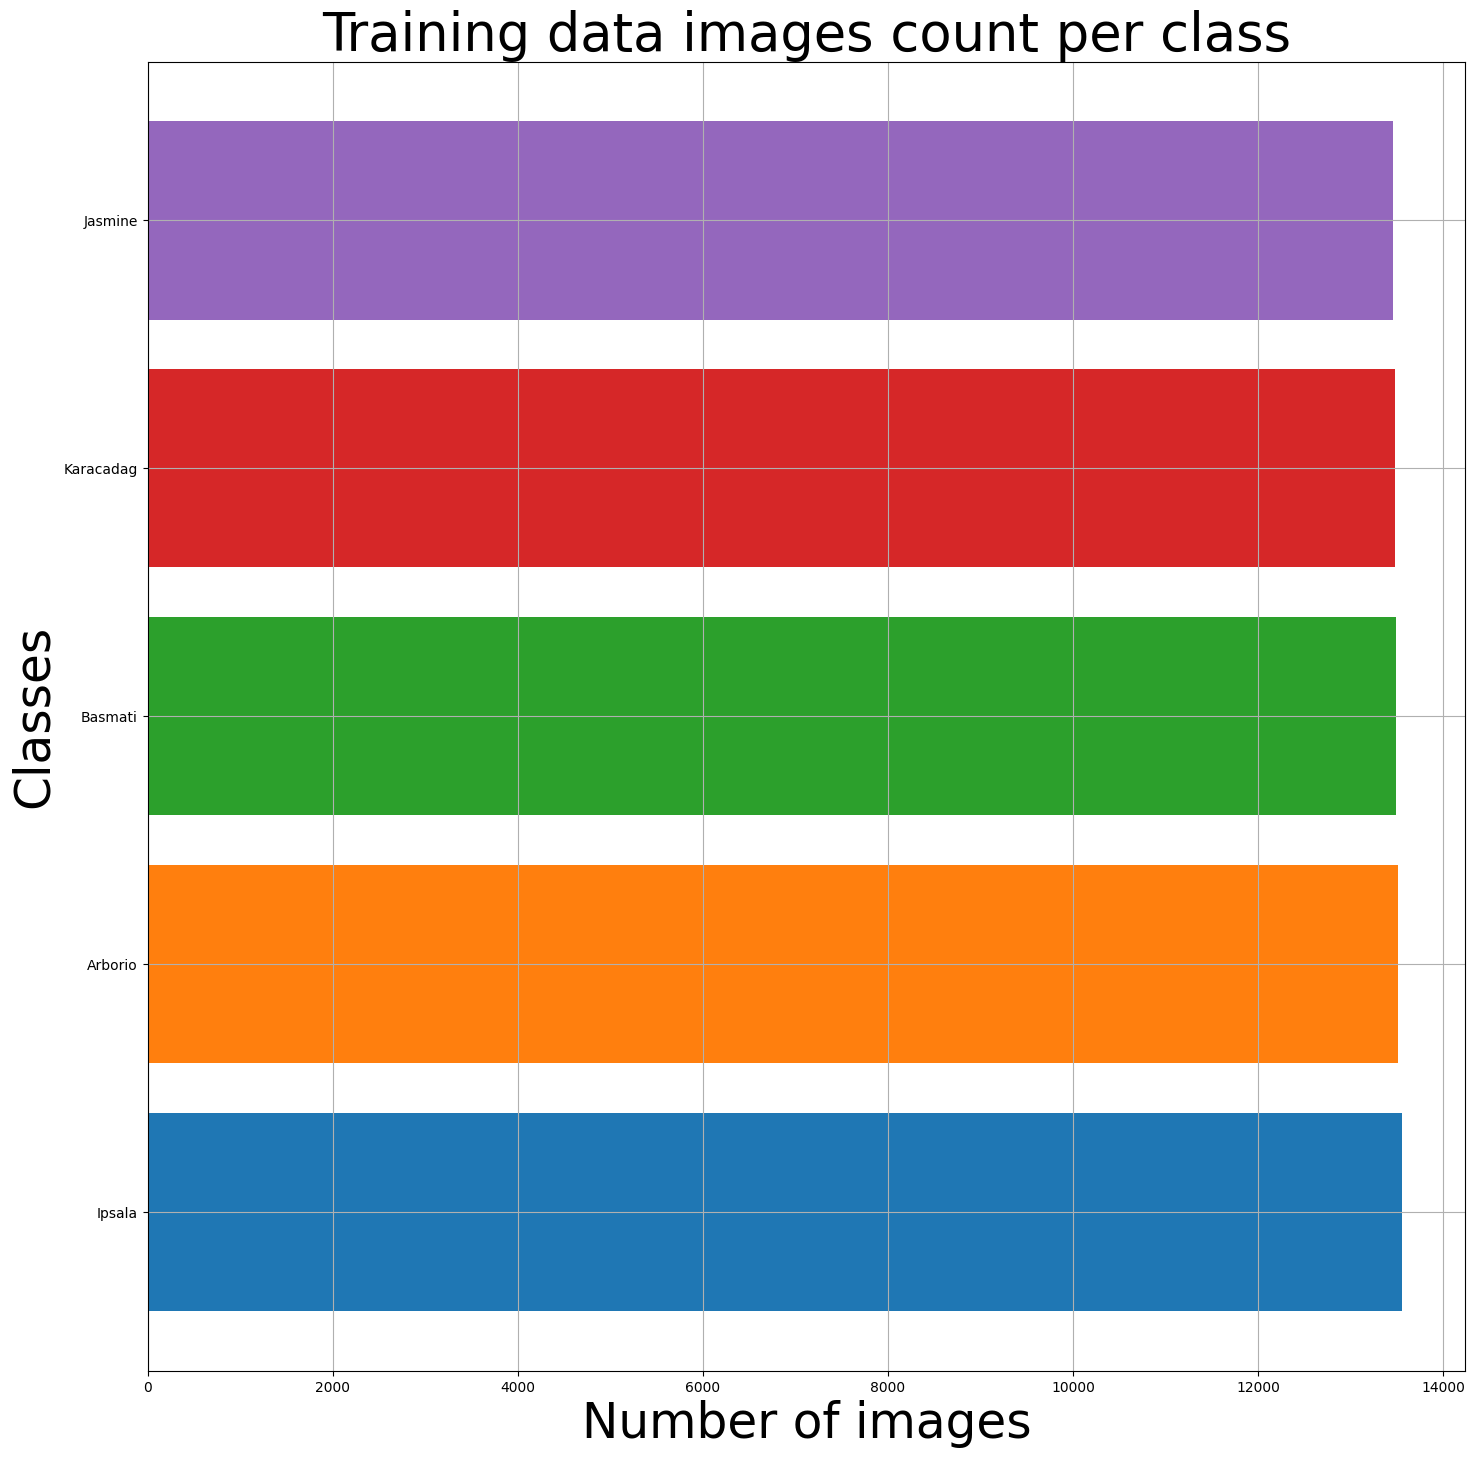

In [4]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
   ]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [5]:
train_df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
1315,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine,3
42008,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala,2
39608,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala,2
26331,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag,4
42684,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati,1
64078,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine,3
42723,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio,0
36274,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio,0
65945,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio,0
50362,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala,2


In [6]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Jasmine
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
(67500, 3)
--------Validation----------
                                             imgpath     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
1  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Arborio
2  /kaggle/input/rice-image-dataset/Rice_Image_Da...  Karacadag
3  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
4  /kaggle/input/rice-image-dataset/Rice_Image_Da...     Ipsala
(6375, 3)
----------Test--------------
                                             imgpath     labels
0  /kaggle/input/rice-image-dataset/Rice_Image_Da...    Arbo

# Show sample from data

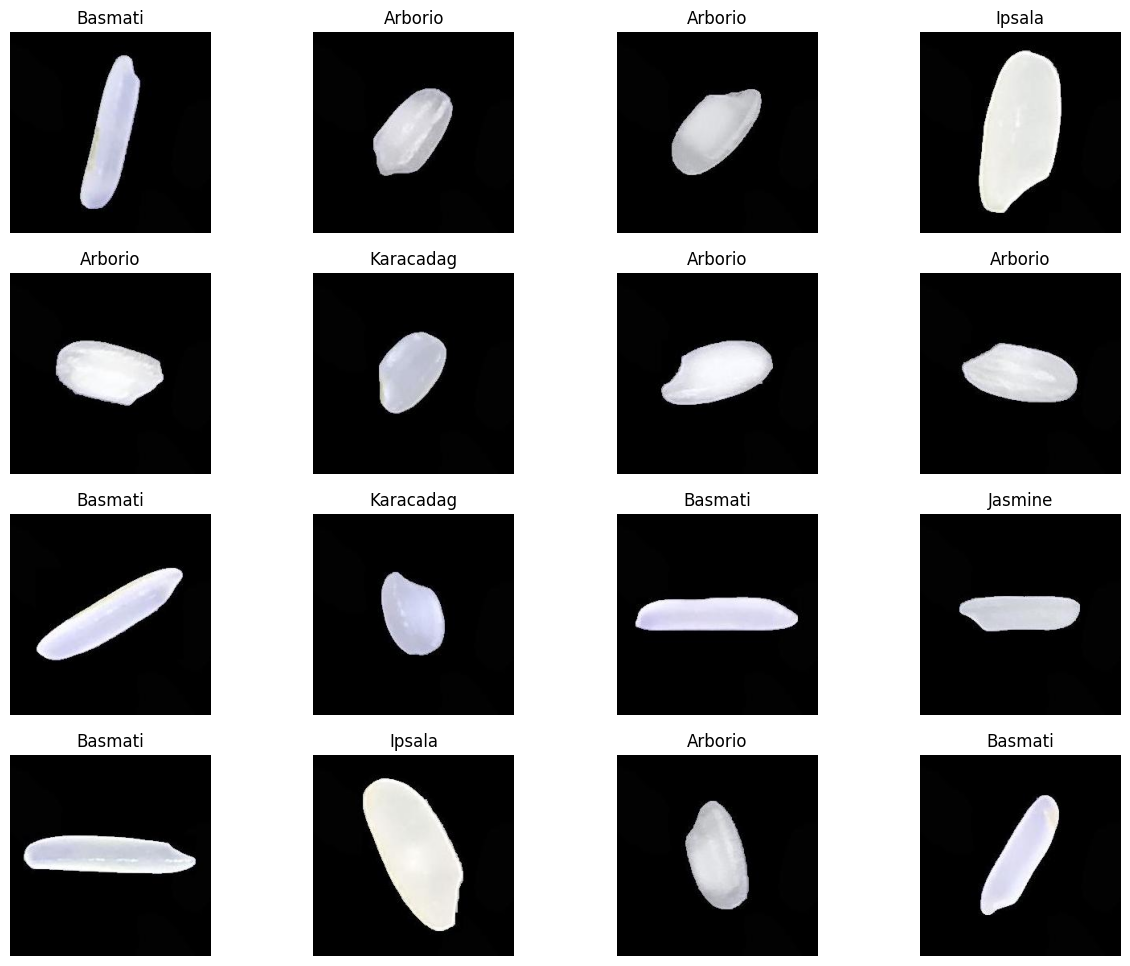

In [7]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [8]:
%%time

BATCH_SIZE = 25
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 67500 validated image filenames belonging to 5 classes.
Found 6375 validated image filenames belonging to 5 classes.
Found 1125 validated image filenames belonging to 5 classes.
CPU times: user 1.43 s, sys: 1.95 s, total: 3.38 s
Wall time: 4min 6s


# Model Structure

In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  

# Training : Transfer Learning

In [11]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 4,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/50
2700/2700 [==============================] - 592s 215ms/step - loss: 0.0499 - accuracy: 0.9836 - val_loss: 0.0614 - val_accuracy: 0.9790 - lr: 5.0000e-04
Epoch 2/50
2700/2700 [==============================] - 147s 54ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0353 - val_accuracy: 0.9889 - lr: 5.0000e-04
Epoch 3/50
2700/2700 [==============================] - 138s 51ms/step - loss: 0.0260 - accuracy: 0.9922 - val_loss: 0.0239 - val_accuracy: 0.9931 - lr: 5.0000e-04
Epoch 4/50
2700/2700 [==============================] - 141s 52ms/step - loss: 0.0242 - accuracy: 0.9925 - val_loss: 0.0592 - val_accuracy: 0.9785 - lr: 5.0000e-04
Epoch 5/50
2700/2700 [==============================] - 144s 53ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0456 - val_accuracy: 0.9846 - lr: 5.0000e-04
Epoch 6/50
2700/2700 [==============================] - 134s 50ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0275 - val_accuracy: 0.9907 - lr: 5.0000e-04
Epoch 7/50
2700

# Display model performance

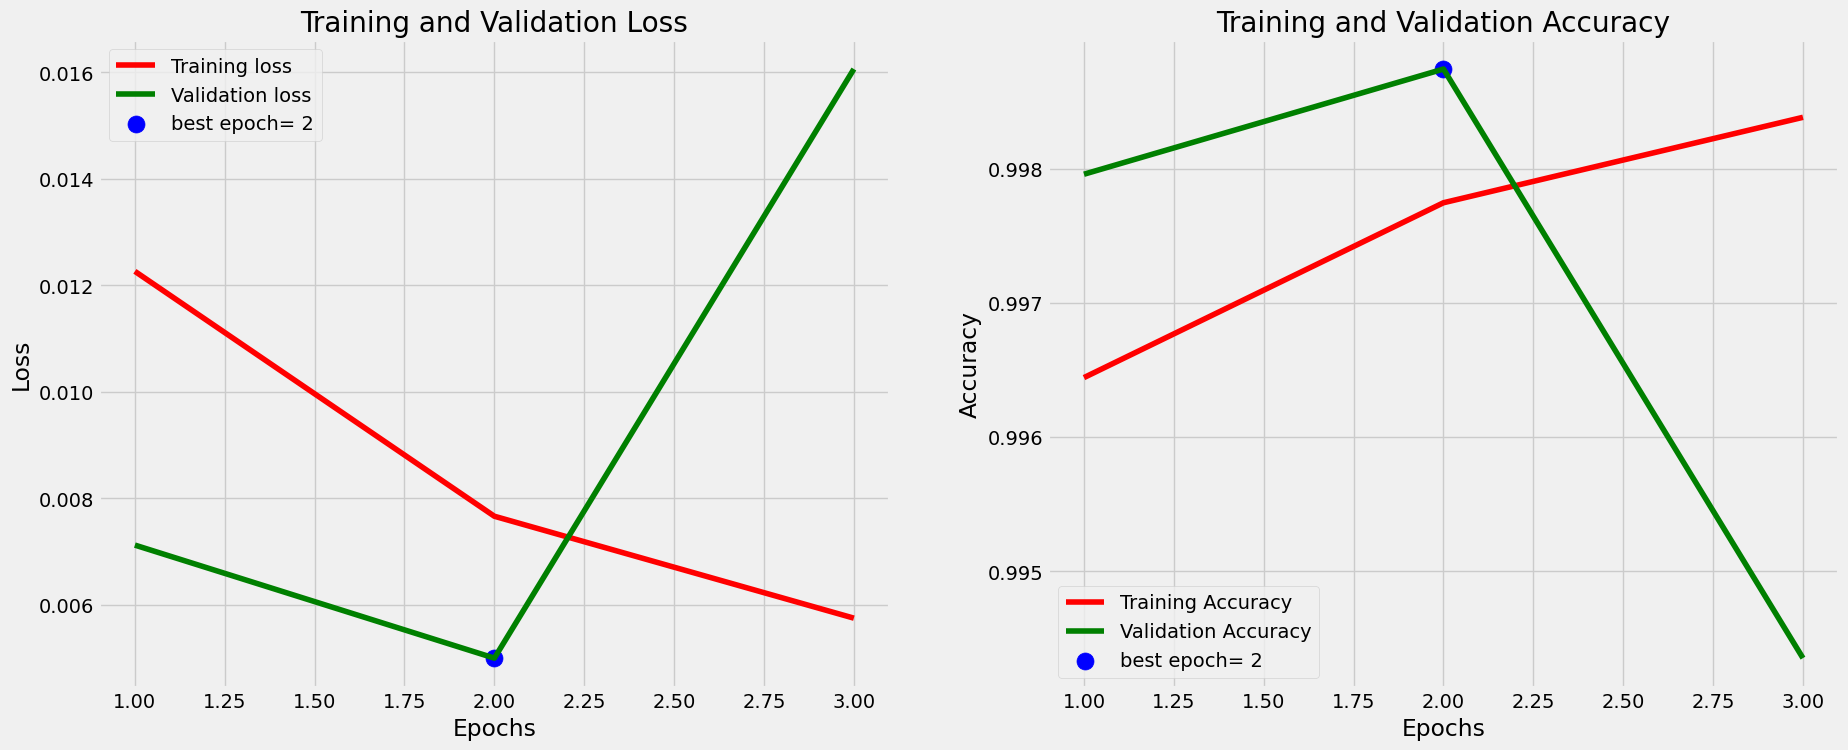

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=3,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

# Display model performance

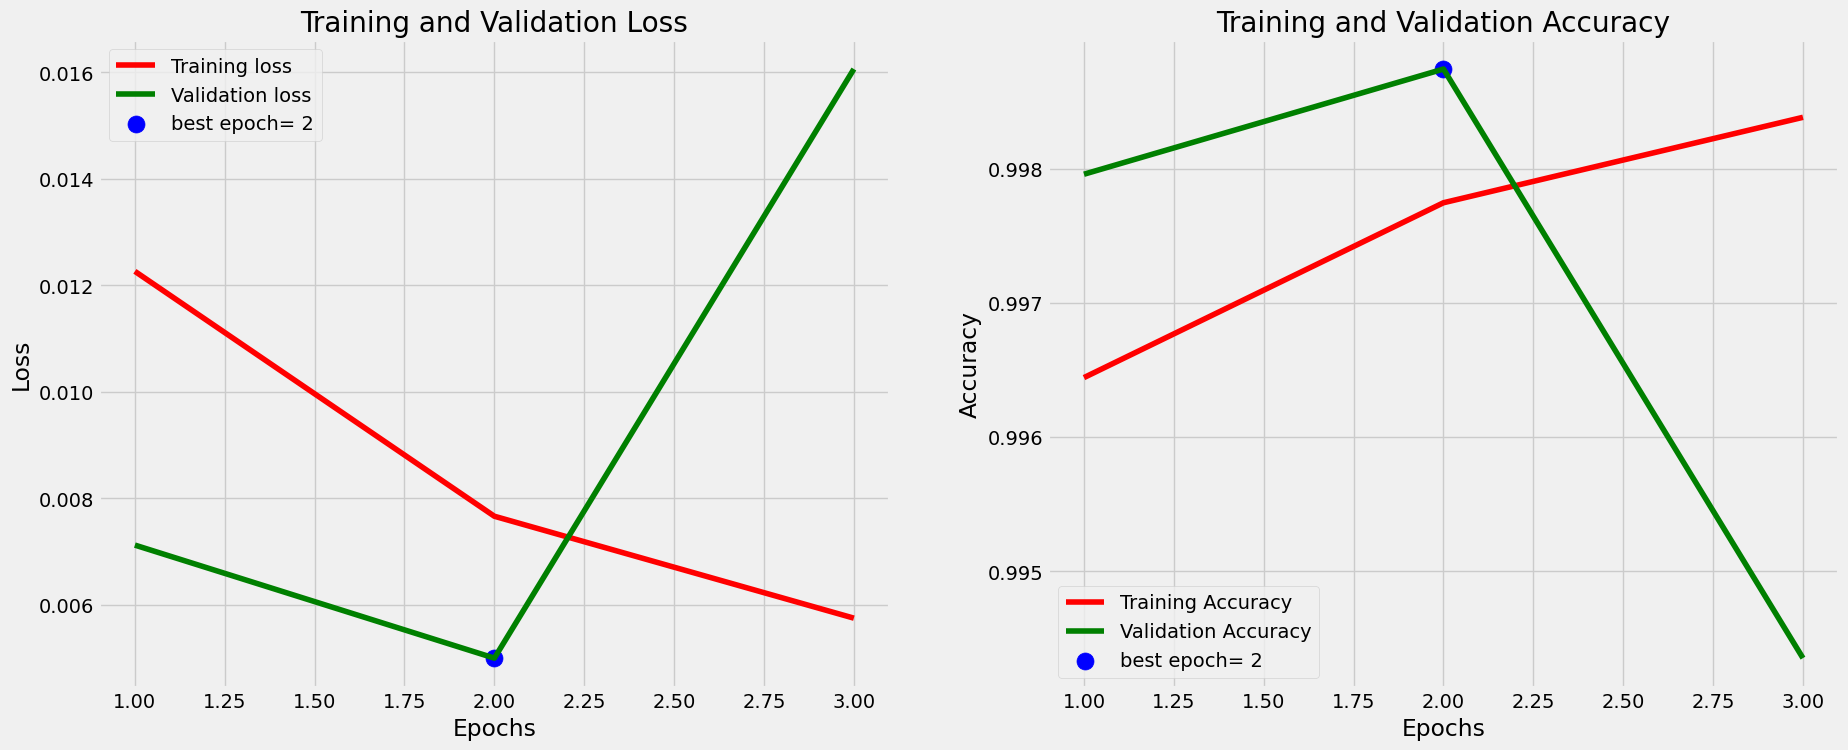

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02379
Test Accuracy: 99.02%


# F1 Score / Recall / Precision

In [16]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

45/45 [==============================] - 4s 42ms/step
F1 Score: 0.9903647142299434
              precision    recall  f1-score   support

     Arborio       0.97      1.00      0.99       209
     Basmati       0.98      1.00      0.99       223
      Ipsala       1.00      1.00      1.00       220
     Jasmine       1.00      0.96      0.98       246
   Karacadag       1.00      1.00      1.00       227

    accuracy                           0.99      1125
   macro avg       0.99      0.99      0.99      1125
weighted avg       0.99      0.99      0.99      1125



# Get Predictions

In [17]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

45/45 [==============================] - 2s 46ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,0,Arborio,0,Arborio,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999996
1,1,1,Basmati,1,Basmati,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999993
2,2,2,Ipsala,2,Ipsala,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999993
3,3,4,Karacadag,4,Karacadag,/kaggle/input/rice-image-dataset/Rice_Image_Da...,1.000000
4,4,0,Arborio,0,Arborio,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999884
5,5,2,Ipsala,2,Ipsala,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999997
6,6,2,Ipsala,2,Ipsala,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999997
7,7,2,Ipsala,2,Ipsala,/kaggle/input/rice-image-dataset/Rice_Image_Da...,0.999969


# Print the most confident errors

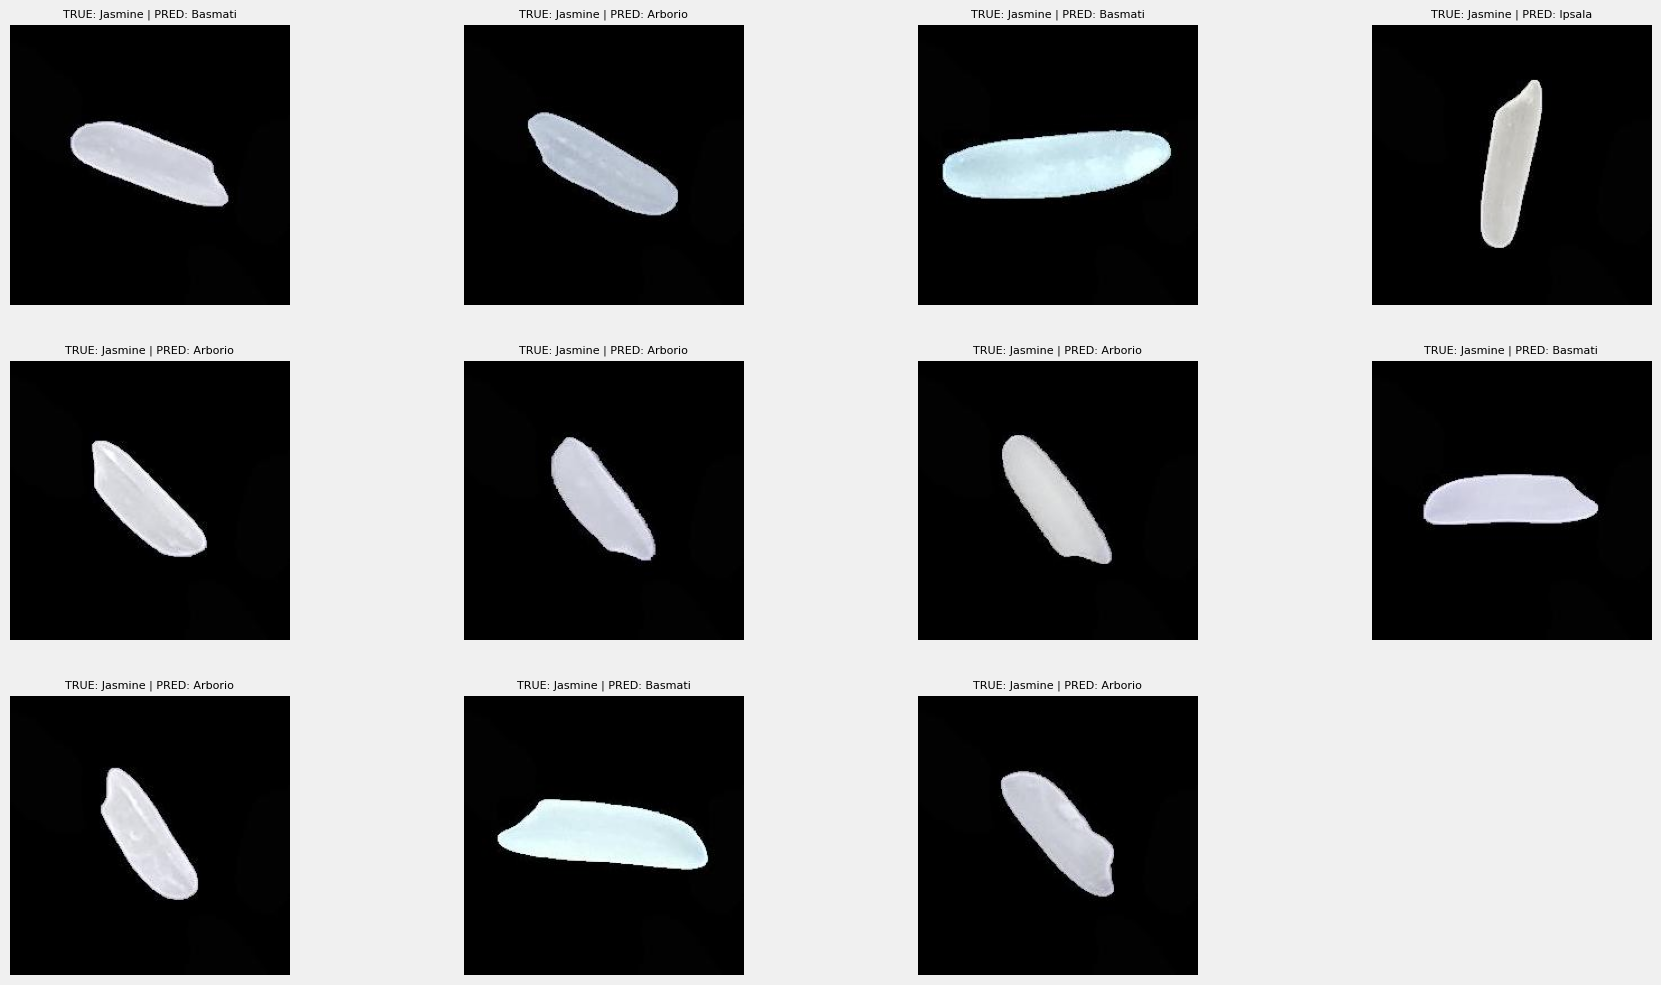

In [18]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

# Confusion Matrics and Classification Report

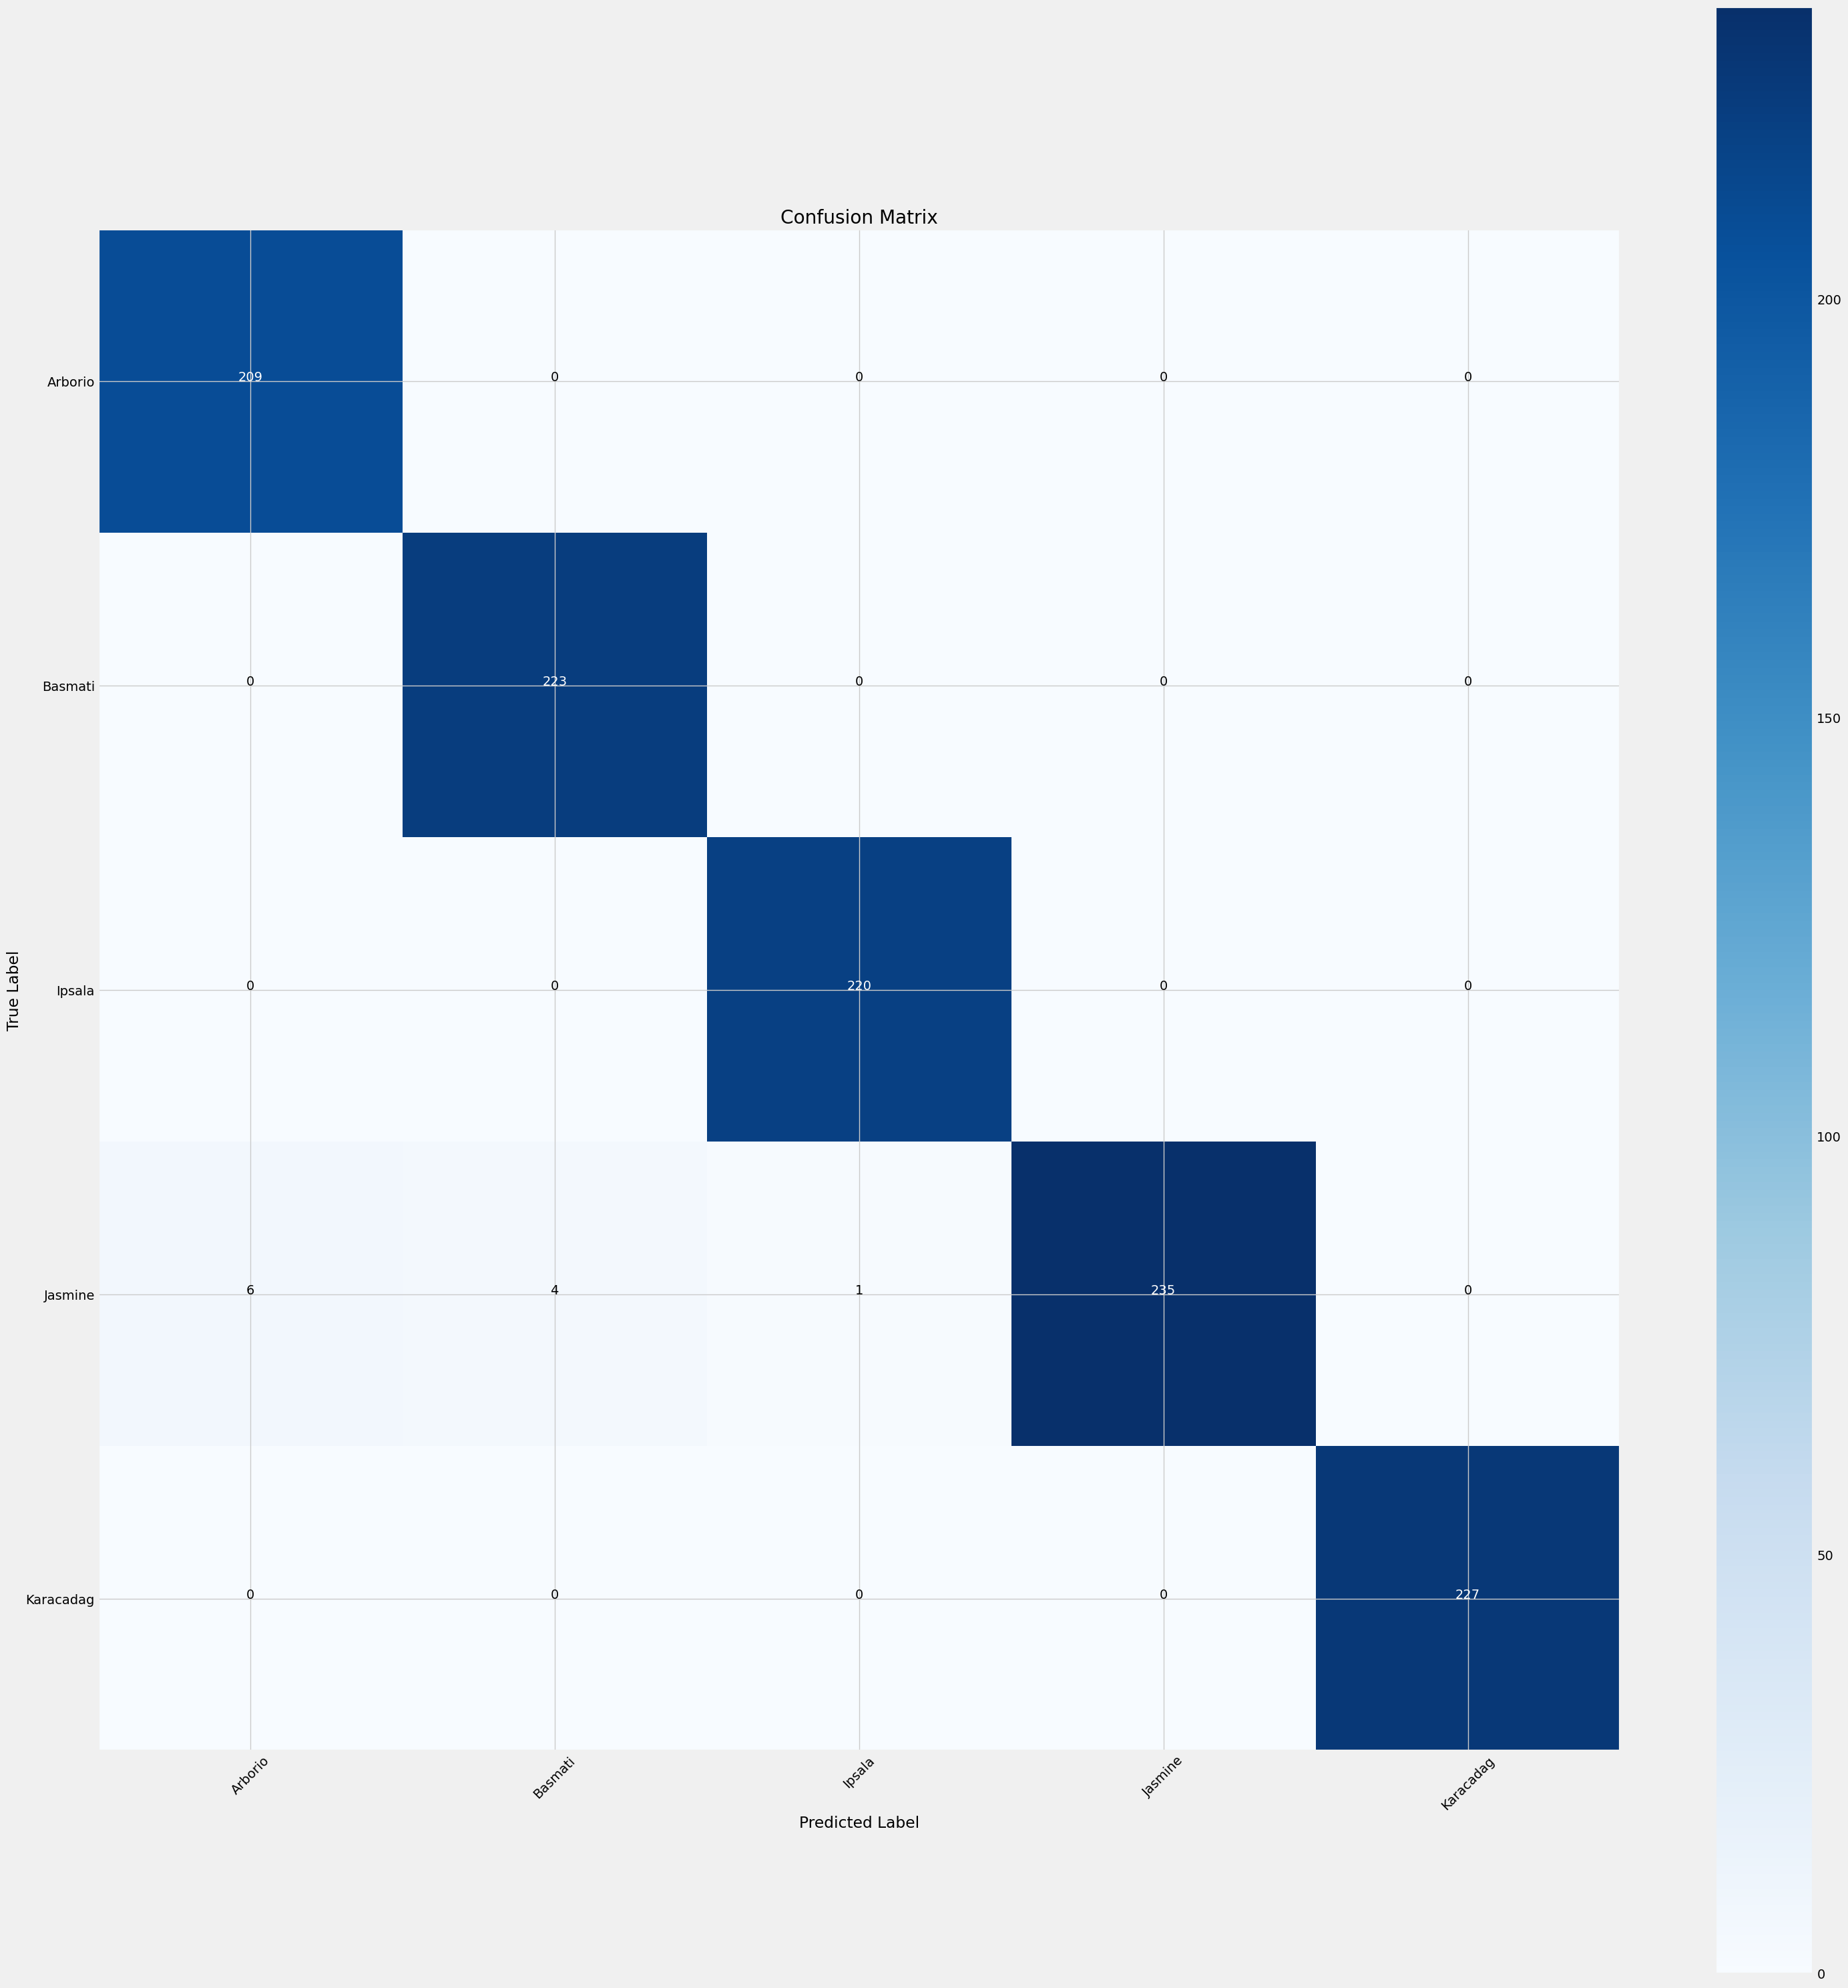

In [19]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()